In [1]:
import matplotlib.pyplot as plt
from autograd import numpy as np
import time
from Inference import Inference
from Subspace import Subspace
from model import Model

from mpl_toolkits.mplot3d import Axes3D
from util import hidecode
# hidecode()            % --------- remember to remove comments after finishing all the code. This function can simplify the code

In [2]:
data = np.genfromtxt(r'../example/hw7_data.csv', delimiter=',')[1:]
x, y = data[:, 0], data[:, 1]

alpha = 1
c = 0
h = lambda x: np.exp(-alpha * (x - c)**2)

###neural network model design choices
width = 5
hidden_layers = 1
input_dim = 1
output_dim = 1

architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': 'rbf',
               'activation_fn_params': 'c=0, alpha=1',
               'activation_fn': h}

# set random state to make the experiments replicable
rand_state = 0
random = np.random.RandomState(rand_state)

# create a model and train the model
my_nn = Model.create(submodel_type="Feedforward", architecture=architecture, Sigma_Y=0.25)

# use MSE result as params_init
params = {'step_size':1e-3, 
          'max_iteration':5000, 
          'random_restarts':1}

# fit my neural network to minimize MSE on the given data
my_nn.fit(x_train=x.reshape((1, -1)), y_train=y.reshape((1, -1)), params=params)

Iteration 0 lower bound 65.1166805377315; gradient mag: 164.73210946091575
Iteration 100 lower bound 52.86436046756695; gradient mag: 56.95458639088457
Iteration 200 lower bound 49.42633385370295; gradient mag: 28.31627548203755
Iteration 300 lower bound 47.73326189562314; gradient mag: 18.311751879565836
Iteration 400 lower bound 46.647745693540806; gradient mag: 13.47755254054697
Iteration 500 lower bound 45.88691542805831; gradient mag: 10.503599898310592
Iteration 600 lower bound 45.25067576634; gradient mag: 8.654932255566825
Iteration 700 lower bound 30.562858257343013; gradient mag: 24.192575322800902
Iteration 800 lower bound 26.97792508592485; gradient mag: 20.354176994190937
Iteration 900 lower bound 24.278363637665734; gradient mag: 18.77912591689822
Iteration 1000 lower bound 22.029867169404948; gradient mag: 17.427416991221943
Iteration 1100 lower bound 20.10610040886032; gradient mag: 16.21045518866593
Iteration 1200 lower bound 18.434367471681025; gradient mag: 15.092044

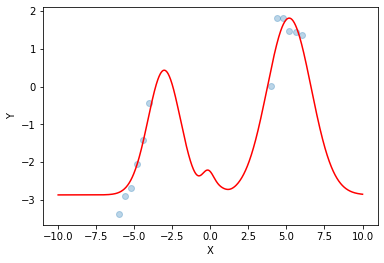

In [3]:
x_test = np.linspace(-10, 10, 1000).reshape(1,-1)
y_test = my_nn.forward(x_test, use_subweights = False, weights = my_nn.weights)[0]
plt.scatter(x, y, alpha = 0.3)
plt.plot(x_test[0], y_test[0], color = 'red')
plt.xlabel('X')
plt.ylabel('Y');

In [4]:
init_weights=my_nn.weights.copy()

# Replicate paper example
## 3 subspaces
Random Subspace

In [5]:
my_subspace_rand = Subspace.create(subspace_type="random", model=my_nn, n_subspace=2)
my_subspace_rand.collect_vector(X=x, y=y)

PCA

In [6]:
my_subspace_pca = Subspace.create(subspace_type="pca", model=my_nn, n_subspace=2)
my_subspace_pca.collect_vector(X=x, y=y)

Curve Subspace

In [ ]:
my_subspace_curve

## Performance with HMC and BBB

In [7]:
bbb_tune_params= {'step_size': 5e-3,
                    'S': 2000,
                    'max_iteration': 5000,
                    'checkpoint': 200,
                    'verbose': True,
                    'position_init': None,
                      'random_restart':1,
                    'init_var': np.exp(-10)}

hmc_tune_params={'step_size':1e-3,
                'leapfrog_steps': 10,
                'total_samples': 20000,
                'burn_in': 0.2,
                'warm_start': True,
                'thinning_factor': 2,
                'mom_std': 1,
                'diagnostic_mode': False}

In [ ]:
time_list=[]
Inference_list=[]
for sub in [my_subspace_rand,my_subspace_pca]:#, my_subspace_curve]:
    for inf,params in zip(['HMC','BBB'],[hmc_tune_params,bbb_tune_params]):
        P,w = my_subspace_rand.get_space()
        Inference_list.append( Inference.create(inference_type=inf, model=my_nn, P=P, w_hat=w, tune_params=params,Sigma_Z=25))
        position_init = my_nn.get_z_from_W(weights=init_weights.copy(), P=P, w_hat=w)
        begin=time.time()
        Inference_list[-1].train(X=x, y=y, warm_start=False, position_init=position_init)
        end=time.time()
        time_list.append(end-begin)

HMC 200: accept rate of 74.5 with step size 0.014950970903496001
HMC 400: accept rate of 71.5 with step size 0.014950970903496001
HMC 600: accept rate of 70.83333333333334 with step size 0.014950970903496001
HMC 800: accept rate of 69.5 with step size 0.014950970903496001
HMC 1000: accept rate of 69.6 with step size 0.014950970903496001
HMC 1200: accept rate of 69.08333333333333 with step size 0.014950970903496001
HMC 1400: accept rate of 69.21428571428572 with step size 0.014950970903496001
HMC 1600: accept rate of 68.875 with step size 0.014950970903496001
HMC 1800: accept rate of 68.72222222222221 with step size 0.014950970903496001
HMC 2000: accept rate of 68.55 with step size 0.014950970903496001
HMC 2200: accept rate of 69.22727272727272 with step size 0.014950970903496001
HMC 2400: accept rate of 69.5 with step size 0.014950970903496001
HMC 2600: accept rate of 69.65384615384616 with step size 0.014950970903496001
HMC 2800: accept rate of 69.60714285714286 with step size 0.01495

HMC 2400: accept rate of 66.875 with step size 0.015431528010142656
HMC 2600: accept rate of 66.76923076923077 with step size 0.015431528010142656
HMC 2800: accept rate of 66.71428571428571 with step size 0.015431528010142656
HMC 3000: accept rate of 66.43333333333334 with step size 0.015431528010142656
HMC 3200: accept rate of 66.53125 with step size 0.015431528010142656
HMC 3400: accept rate of 66.32352941176471 with step size 0.015431528010142656
HMC 3600: accept rate of 66.47222222222223 with step size 0.015431528010142656
HMC 3800: accept rate of 66.26315789473685 with step size 0.015431528010142656
HMC 200: accept rate of 67.0
HMC 400: accept rate of 57.75
HMC 600: accept rate of 66.33333333333333
HMC 800: accept rate of 73.5
HMC 1000: accept rate of 76.0
HMC 1200: accept rate of 77.0
HMC 1400: accept rate of 78.92857142857143
HMC 1600: accept rate of 79.375
HMC 1800: accept rate of 79.22222222222223
HMC 2000: accept rate of 78.0
HMC 2200: accept rate of 75.18181818181819
HMC 240

## Compare results

In [90]:
zx=np.linspace(-0.1,0.1,10)
zy=np.linspace(-0.1,0.1,10)
zx,zy=np.meshgrid(zx,zy)

In [91]:
z=np.array([zx,zy]).reshape(2,-1).T
level = HMC_rand.get_posterior_likelihood(z=z,X=x,y=y).reshape(10,10)

In [84]:
post_z=HMC_rand.get_posterior(10)
post_level=HMC_rand.get_posterior_likelihood(z=post_z,X=x,y=y)

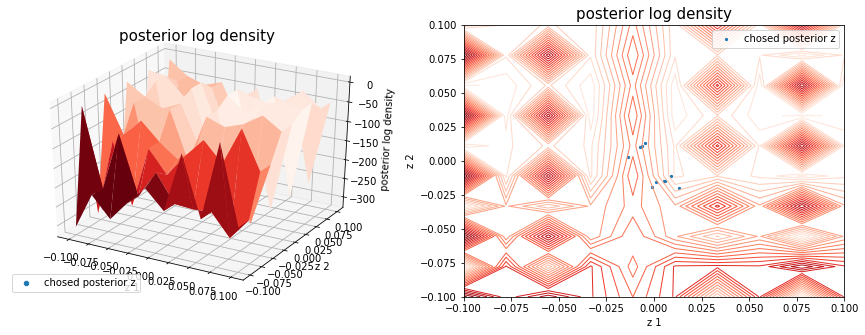

In [92]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(zx,zy,level,cmap='Reds_r', edgecolor='none')
ax.scatter3D(post_z[:,0],post_z[:,1],post_level,label='chosed posterior z')
plt.title('posterior log density',fontsize=15)
ax.set_xlabel('z 1')
ax.set_ylabel('z 2')
ax.set_zlabel('posterior log density')
plt.legend(loc='lower left')
ax1= fig.add_subplot(122)
ax1.contour(zx, zy, level, levels=20, linewidths=1,cmap='Reds_r')
ax1.scatter(post_z[:,0],post_z[:,1],label='chosed posterior z',s=5)
plt.xlabel('z 1')
plt.ylabel('z 2')
plt.title('posterior log density',fontsize=15)
plt.legend()



In [52]:
zx.shape

(100, 100)

In [53]:
np.array([zx,zy]).shape

(2, 100, 100)

In [29]:
z=np.array([zx,zy]).reshape(2,-1).T

In [32]:
level = HMC_rand.get_posterior_likelihood(z=z,X=x,y=y)

In [47]:
z

array([[-3.        , -3.        ],
       [-2.93939394, -3.        ],
       [-2.87878788, -3.        ],
       ...,
       [ 2.87878788,  3.        ],
       [ 2.93939394,  3.        ],
       [ 3.        ,  3.        ]])

In [42]:
zx.reshape(-1)

array([-3.        , -2.93939394, -2.87878788, ...,  2.87878788,
        2.93939394,  3.        ])

In [48]:
zx

array([[-3.        , -2.93939394, -2.87878788, ...,  2.87878788,
         2.93939394,  3.        ],
       [-3.        , -2.93939394, -2.87878788, ...,  2.87878788,
         2.93939394,  3.        ],
       [-3.        , -2.93939394, -2.87878788, ...,  2.87878788,
         2.93939394,  3.        ],
       ...,
       [-3.        , -2.93939394, -2.87878788, ...,  2.87878788,
         2.93939394,  3.        ],
       [-3.        , -2.93939394, -2.87878788, ...,  2.87878788,
         2.93939394,  3.        ],
       [-3.        , -2.93939394, -2.87878788, ...,  2.87878788,
         2.93939394,  3.        ]])

In [46]:
level

array([-1140.15600321, -1566.90292784, -1081.75761391, ...,
        -125.75423651, -3484.99741111,  -125.76848812])

In [44]:
level.reshape(100,100)

array([[-1140.15600321, -1566.90292784, -1081.75761391, ...,
        -1566.89587549,   -48.21809905, -1566.9101271 ],
       [  -53.67694665, -1566.89572857,  -250.58594722, ...,
        -1566.88867623, -3484.99021184, -1566.90292784],
       [-1140.1417516 , -1497.46401022, -1081.74336231, ...,
        -1497.45695788,   -48.20384744, -1497.47120949],
       ...,
       [  -53.66989431,  -113.9642781 ,  -250.57889488, ...,
         -113.95722576, -3484.9831595 ,  -113.97147737],
       [-1140.14880394,  -125.75408959, -1081.75041465, ...,
         -125.74703725,   -48.21089979,  -125.76128886],
       [  -53.68414592,  -125.76128886,  -250.59314649, ...,
         -125.75423651, -3484.99741111,  -125.76848812]])

In [37]:
zx

array([[-3.        , -2.93939394, -2.87878788, ...,  2.87878788,
         2.93939394,  3.        ],
       [-3.        , -2.93939394, -2.87878788, ...,  2.87878788,
         2.93939394,  3.        ],
       [-3.        , -2.93939394, -2.87878788, ...,  2.87878788,
         2.93939394,  3.        ],
       ...,
       [-3.        , -2.93939394, -2.87878788, ...,  2.87878788,
         2.93939394,  3.        ],
       [-3.        , -2.93939394, -2.87878788, ...,  2.87878788,
         2.93939394,  3.        ],
       [-3.        , -2.93939394, -2.87878788, ...,  2.87878788,
         2.93939394,  3.        ]])

In [34]:
level.reshape(100,100)

array([[-1140.15600321, -1566.90292784, -1081.75761391, ...,
        -1566.89587549,   -48.21809905, -1566.9101271 ],
       [  -53.67694665, -1566.89572857,  -250.58594722, ...,
        -1566.88867623, -3484.99021184, -1566.90292784],
       [-1140.1417516 , -1497.46401022, -1081.74336231, ...,
        -1497.45695788,   -48.20384744, -1497.47120949],
       ...,
       [  -53.66989431,  -113.9642781 ,  -250.57889488, ...,
         -113.95722576, -3484.9831595 ,  -113.97147737],
       [-1140.14880394,  -125.75408959, -1081.75041465, ...,
         -125.74703725,   -48.21089979,  -125.76128886],
       [  -53.68414592,  -125.76128886,  -250.59314649, ...,
         -125.75423651, -3484.99741111,  -125.76848812]])

In [26]:
zx.reshape(1,-1)

array([[-3.        , -2.93939394, -2.87878788, ...,  2.87878788,
         2.93939394,  3.        ]])

In [27]:
zy.reshape(1,-1)

array([[-3., -3., -3., ...,  3.,  3.,  3.]])

In [24]:
zx.reshape(1,-1)

array([[-3.        , -2.93939394, -2.87878788, ...,  2.87878788,
         2.93939394,  3.        ]])

array([[-3.        , -3.        ],
       [-2.93939394, -3.        ],
       [-2.87878788, -3.        ],
       ...,
       [ 2.87878788,  3.        ],
       [ 2.93939394,  3.        ],
       [ 3.        ,  3.        ]])

In [22]:
zy

array([[-3.        , -3.        , -3.        , ..., -3.        ,
        -3.        , -3.        ],
       [-2.93939394, -2.93939394, -2.93939394, ..., -2.93939394,
        -2.93939394, -2.93939394],
       [-2.87878788, -2.87878788, -2.87878788, ..., -2.87878788,
        -2.87878788, -2.87878788],
       ...,
       [ 2.87878788,  2.87878788,  2.87878788, ...,  2.87878788,
         2.87878788,  2.87878788],
       [ 2.93939394,  2.93939394,  2.93939394, ...,  2.93939394,
         2.93939394,  2.93939394],
       [ 3.        ,  3.        ,  3.        , ...,  3.        ,
         3.        ,  3.        ]])

In [17]:
zx

array([[-3.        , -2.93939394, -2.87878788, ...,  2.87878788,
         2.93939394,  3.        ],
       [-3.        , -2.93939394, -2.87878788, ...,  2.87878788,
         2.93939394,  3.        ],
       [-3.        , -2.93939394, -2.87878788, ...,  2.87878788,
         2.93939394,  3.        ],
       ...,
       [-3.        , -2.93939394, -2.87878788, ...,  2.87878788,
         2.93939394,  3.        ],
       [-3.        , -2.93939394, -2.87878788, ...,  2.87878788,
         2.93939394,  3.        ],
       [-3.        , -2.93939394, -2.87878788, ...,  2.87878788,
         2.93939394,  3.        ]])

In [ ]:
HMC_rand.get_posterior_likelihood(z=)

In [45]:
zmin=np.min(post_sample,axis=0)
zmax=np.max(post_sample,axis=0)
alpha=10
zx = np.linspace(-alpha*abs(zmin[0])+zmin[0], alpha*abs(zmin[0])+zmin[0],100)
zy = np.linspace(-alpha*abs(zmin[1])+zmin[1], alpha*abs(zmin[1])+zmin[1],100)
zz=np.array(np.meshgrid(zx,zy)).reshape(2,-1).T

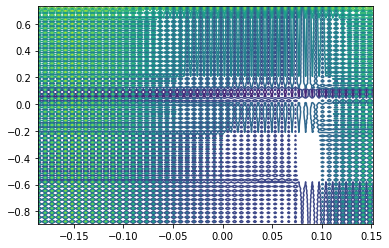

In [61]:
plt.contour(zx,zy,z.reshape(100,100))

In [46]:
zz

array([[-0.18553989, -0.89276979],
       [-0.18213236, -0.89276979],
       [-0.17872483, -0.89276979],
       ...,
       [ 0.14499031,  0.73044801],
       [ 0.14839783,  0.73044801],
       [ 0.15180536,  0.73044801]])

In [47]:
zz

array([[-0.18553989, -0.89276979],
       [-0.18213236, -0.89276979],
       [-0.17872483, -0.89276979],
       ...,
       [ 0.14499031,  0.73044801],
       [ 0.14839783,  0.73044801],
       [ 0.15180536,  0.73044801]])

In [48]:
HMC_rand.get_posterior_likelihood(zz, X=x,y=y)

(10000,)
(10000,)


-220.13074392970955

In [49]:
log_lk = HMC_rand.model.get_likelihood(X=x.reshape(1,-1), y=y.reshape(1,1,-1), use_subweights=True, z=zz, P=P, w_hat=w)

In [51]:
log_lk.shape

(10000,)

In [52]:
zz.shape

(10000, 2)

In [57]:
def get_posterior_likelihood(self, z, X, y):
    """
    return `n_samples` log likelihood of data. P(W|D). Use MC estimates
    """
    X = X.reshape(self.model.params['D_in'], -1)
    y = y.reshape(1, self.model.params['D_out'], -1)
    log_lk = self.model.get_likelihood(X=X, y=y, use_subweights=True, z=z, P=self.P, w_hat=self.w_hat)
    log_prior = self.log_prior(z)
    return log_prior+log_lk

In [58]:
z = get_posterior_likelihood(HMC_rand, zz,x,y)

In [59]:
z

array([-273.90093459, -271.39231676, -273.727163  , ..., -116.74155003,
       -239.24109955, -116.74159048])

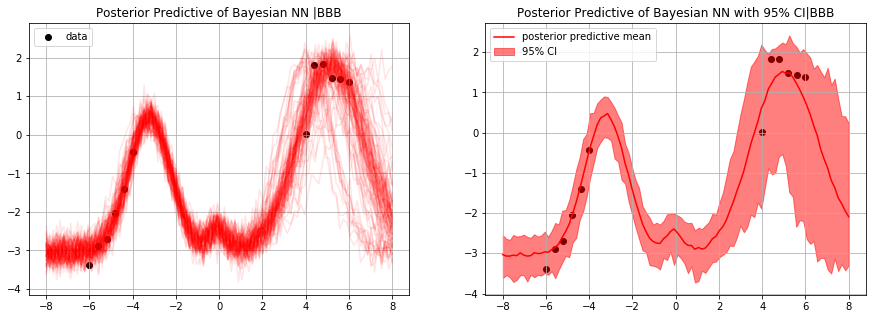

In [16]:
n_sample=100
post_sample = HMC_rand.get_posterior(n_samples=n_sample)
x_test = np.linspace(-8, 8, 100)
y_test_bnn = my_nn.forward(P=P, w_hat=w,z=post_sample, X=x_test.reshape((1, -1))).reshape(100, 100) + np.random.normal(0, my_nn.Sigma_Y_det, size = (100, 100))
# plot
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.grid()
plt.title('Posterior Predictive of Bayesian NN |BBB')
# plt.ylim(-15, 15)
for i in range(n_sample):
    plt.plot(x_test, y_test_bnn[i], color='red', alpha=max(1 / n_sample, 0.1))
plt.scatter(x, y, color='black', label='data')
plt.legend()
plt.subplot(1, 2, 2)
plt.scatter(x, y, color='black')
plt.plot(x_test, y_test_bnn.mean(0), color='red', label='posterior predictive mean')
plt.fill_between(x_test, np.percentile(y_test_bnn, 0.25, axis=0), np.percentile(y_test_bnn, 97.5, axis=0),
                 color='red', label='95% CI', alpha=0.5)
plt.legend(loc='best')
plt.title('Posterior Predictive of Bayesian NN with 95% CI|BBB')
plt.grid()
# plt.ylim(-15, 15)
plt.show()

# Subspace Sensitivity Test

In [1]:
import matplotlib.pyplot as plt
from autograd import numpy as np
import time
from src.Inference import Inference
from src.Subspace import Subspace
from src.model import Model
from src.util import hidecode
# hidecode()            % --------- remember to remove comments after finishing all the code. This function can simplify the code

In [2]:
# data = np.load(r'.\example\data.npy')
data = np.genfromtxt(r'.\example\hw7_data.csv', delimiter=',')[1:]
x, y = data[:, 0], data[:, 1]

alpha = 1
c = 0
h = lambda x: np.exp(-alpha * (x - c)**2)

###neural network model design choices
width = 5
hidden_layers = 1
input_dim = 1
output_dim = 1

architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': 'rbf',
               'activation_fn_params': 'c=0, alpha=1',
               'activation_fn': h}

# set random state to make the experiments replicable
rand_state = 0
random = np.random.RandomState(rand_state)

# create a model and train the model
my_nn = Model.create(submodel_type="Feedforward", architecture=architecture)

# use MSE result as params_init
params = {'step_size':1e-3, 
          'max_iteration':5000, 
          'random_restarts':1}

# fit my neural network to minimize MSE on the given data
my_nn.fit(x_train=x.reshape((1, -1)), y_train=y.reshape((1, -1)), params=params)

Iteration 0 lower bound 65.1166805377315; gradient mag: 164.73210946091575
Iteration 100 lower bound 52.86436046756695; gradient mag: 56.95458639088457
Iteration 200 lower bound 49.42633385370295; gradient mag: 28.31627548203755
Iteration 300 lower bound 47.73326189562314; gradient mag: 18.311751879565836
Iteration 400 lower bound 46.647745693540806; gradient mag: 13.47755254054697
Iteration 500 lower bound 45.88691542805831; gradient mag: 10.503599898310592
Iteration 600 lower bound 45.25067576634; gradient mag: 8.654932255566825
Iteration 700 lower bound 30.562858257343013; gradient mag: 24.192575322800902
Iteration 800 lower bound 26.97792508592485; gradient mag: 20.354176994190937
Iteration 900 lower bound 24.278363637665734; gradient mag: 18.77912591689822
Iteration 1000 lower bound 22.029867169404948; gradient mag: 17.427416991221943
Iteration 1100 lower bound 20.10610040886032; gradient mag: 16.21045518866593
Iteration 1200 lower bound 18.434367471681025; gradient mag: 15.092044

Text(0, 0.5, 'Y')

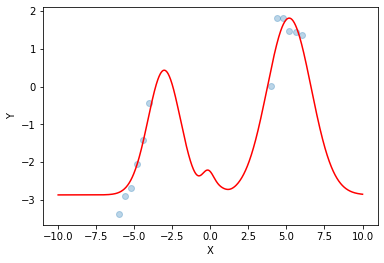

In [3]:
x_test = np.linspace(-10, 10, 1000).reshape(1,-1)
y_test = my_nn.forward(x_test, use_subweights = False, weights = my_nn.weights)[0]
plt.scatter(x, y, alpha = 0.3)
plt.plot(x_test[0], y_test[0], color = 'red')
plt.xlabel('X')
plt.ylabel('Y')


In [20]:
# my_nn = Model.create(submodel_type="Feedforward", architecture=architecture,Sigma_Y=0.25)
my_subspace = Subspace.create(subspace_type="random", model=my_nn, n_subspace=2)
my_subspace.collect_vector(X=x, y=y)
P, w = my_subspace.get_space()
# raw weight: 
# P=np.eye(P.shape[0])
# w=np.zeros_like(w)

In [21]:
hmc_tune_params={'step_size':1e-2,
                                'leapfrog_steps': 10,
                                'total_samples': 10000,
                                'burn_in': 0.2,
                                'warm_start': False,
                                'thinning_factor': 2,
                                'mom_std': 1,
                                'diagnostic_mode': False}

In [22]:
my_inference = Inference.create(inference_type="HMC", model=my_nn, P=P, w_hat=w,  tune_params=hmc_tune_params,
                               Sigma_Z=25)

In [23]:
# get initial weights (in subspace dimension!!)
position_init = my_nn.get_z_from_W(weights=my_nn.weights, P=my_inference.P, w_hat=my_inference.w_hat)

In [24]:
begin=time.time()
my_inference.train(X=x, y=y, warm_start=False, position_init=position_init)
end=time.time()

HMC 200: accept rate of 100.0 with step size 0.01
HMC 400: accept rate of 98.0 with step size 0.011497094710845077
HMC 600: accept rate of 97.0 with step size 0.012899830386210715
HMC 800: accept rate of 96.125 with step size 0.014399830386210715
HMC 1000: accept rate of 95.89999999999999 with step size 0.015899830386210716
HMC 1200: accept rate of 94.83333333333334 with step size 0.017399830386210718
HMC 1400: accept rate of 94.14285714285714 with step size 0.01756014620264444
HMC 1600: accept rate of 93.8125 with step size 0.0173783926915037
HMC 1800: accept rate of 93.44444444444444 with step size 0.018558611422574426
HMC 200: accept rate of 91.5
HMC 400: accept rate of 89.25
HMC 600: accept rate of 91.16666666666667
HMC 800: accept rate of 91.375
HMC 1000: accept rate of 92.1
HMC 1200: accept rate of 92.16666666666667
HMC 1400: accept rate of 91.85714285714286
HMC 1600: accept rate of 91.75
HMC 1800: accept rate of 91.44444444444444
HMC 2000: accept rate of 91.05
HMC 2200: accept r

In [25]:
print('It costs {:.2f} min'.format((end-begin)/60))

It costs 6.58 min


In [30]:
# get posterior z
n_sample = 100
post_sample = my_inference.get_posterior(n_samples=n_sample)
x_test = np.linspace(-8, 8, 100)
y_test_bnn = my_nn.forward(P=P, w_hat=w,z=post_sample, X=x_test.reshape((1, -1))).reshape(100, 100) + np.random.normal(0, my_nn.Sigma_Y_det, size = (100, 100))
# x_test = np.linspace(-8, 8, 100)
# y_test = np.reshape(
#     [my_nn.forward(P=P, w_hat=w, z=post_sample[i], X=x_test.reshape(1, -1)) for i in range(n_sample)],
#     (n_sample, -1)) \
#          + np.random.normal(0, my_nn.Sigma_Y_det ** 0.5, size=(n_sample, len(x_test)))
# because here Sigma_Y is 1-D, so determinants=its value

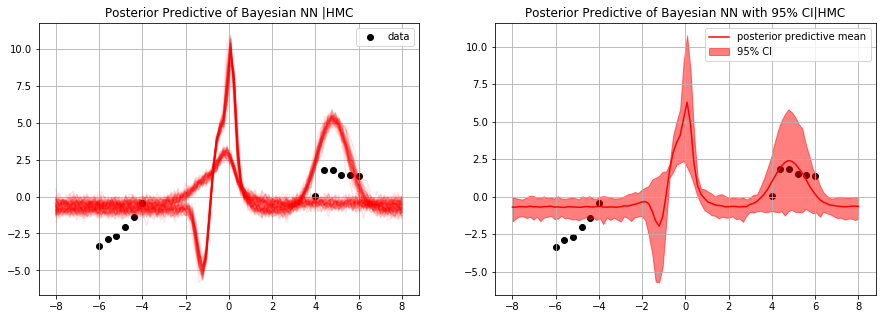

In [31]:
# plot
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.grid()
plt.title('Posterior Predictive of Bayesian NN |HMC')
# plt.ylim(-15, 15)
for i in range(n_sample):
    plt.plot(x_test, y_test_bnn[i], color='red', alpha=max(1 / n_sample, 0.1))
plt.scatter(x, y, color='black', label='data')
plt.legend()
plt.subplot(1, 2, 2)
plt.scatter(x, y, color='black')
plt.plot(x_test, y_test_bnn.mean(0), color='red', label='posterior predictive mean')
plt.fill_between(x_test, np.percentile(y_test_bnn, 0.25, axis=0), np.percentile(y_test_bnn, 97.5, axis=0),
                 color='red', label='95% CI', alpha=0.5)
plt.legend(loc='best')
plt.title('Posterior Predictive of Bayesian NN with 95% CI|HMC')
plt.grid()
# plt.ylim(-15, 15)
plt.show()

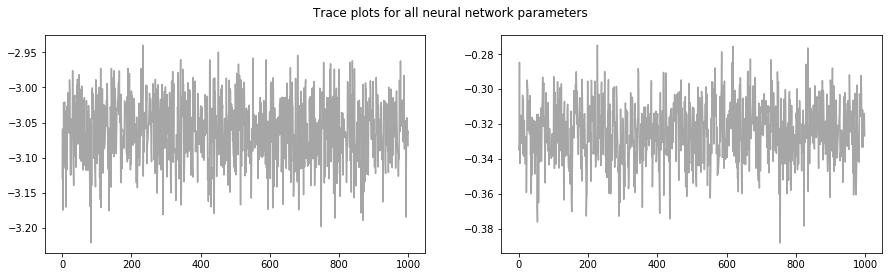

In [46]:
post_sample=my_inference.get_posterior(n_samples=1000)
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
for i in range(my_inference.D_z):
#     row = 1
    col = i % 2
    ax[col].plot(range(len(post_sample)), post_sample[:, i], color='gray', alpha=0.7)
fig.suptitle('Trace plots for all neural network parameters')
plt.show()